In [1]:
import sys
sys.path.append('../src')

import torch
from imgaug import augmenters as iaa
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from config import DATASET_DIR, CLASS_TO_ID
from visual import *
from dataset import *

In [5]:
model = OneFormerForUniversalSegmentation.from_pretrained("shi-labs/oneformer_coco_dinat_large", is_training=True)
processor = OneFormerProcessor.from_pretrained("shi-labs/oneformer_coco_dinat_large")
processor.image_processor.num_text = model.config.num_queries - model.config.text_encoder_n_ctx

Some weights of OneFormerForUniversalSegmentation were not initialized from the model checkpoint at shi-labs/oneformer_coco_dinat_large and are newly initialized: ['model.text_mapper.prompt_ctx.weight', 'model.text_mapper.text_encoder.ln_final.bias', 'model.text_mapper.text_encoder.ln_final.weight', 'model.text_mapper.text_encoder.positional_embedding', 'model.text_mapper.text_encoder.token_embedding.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.layer_norm2.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc1.weight', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.bias', 'model.text_mapper.text_encoder.transformer.layers.0.mlp.fc2.weight', 'model.text_mapper.

In [21]:
# processor.image_processor.repo_path
# processor.image_processor.class_info_file

'coco_panoptic.json'

In [9]:
dataset_train = GalaxyDataset(DATASET_DIR, "train", CLASS_TO_ID, processor)

In [10]:
dataset_val = GalaxyDataset(DATASET_DIR, "val", CLASS_TO_ID, processor)

In [14]:
dataset_test = GalaxyDataset(DATASET_DIR, "test", CLASS_TO_ID, processor)

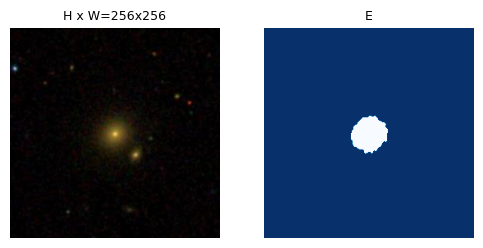

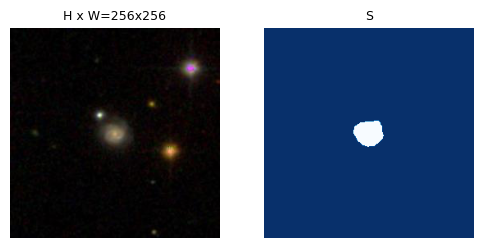

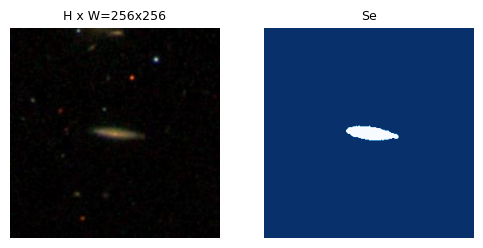

In [11]:
display_n_samples(dataset_train, 3)